In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
import torch.utils.data

We will talk about Convolutional Neural Networks (CNNs) which have dominated the image-based domains.


Like last class, we will focus on the MNIST dataset. However, we are going to make a small change. Notice the *reshape* call. Why are we re-shaping the data? We are doing it to impose some structural information. We were used to 2D *tensor*:

$$(N, D)$$

where $N=$ the number of data points, and $D=$ the number of features. We could re-arange the columns ($D$), and nothing would really change.

Now that we are imposing some structure, this won't be true. We will work with a tensor that is 4D:

$$(N, C, H, W)$$

Again, $N=$ the number of data points. But now we have $C=$ the number of *channels* in the image, $W=$ the *width* of the image, and $H=$ the *height* of the image. If we wanted, we could recover $D=C\cdot W \cdot H$.

For our data, there is one-channel because our images are grayscale. If we had a normal color image, we would often have $C=3$, one for Red, Green, and Blue.

In [ ]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype(np.float32)/255
y = y.astype(np.int32)
# Data has been fetched as a Dataframe, but we will need them as np arrays, so lets convert
# Pandas use the loc attribute to return one or more specified row(s)
# print(X.loc[8])
X = np.array(X.loc[:])
y = np.array(y)

#Different form ordinary NN lecture, we use data as 28x28 matrices
X = X.reshape(X.shape[0], 1, 28, 28)   #(N,C,H,W)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(56000, 1, 28, 28)
(14000, 1, 28, 28)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# The 'TensorDataset' class in PyTorch is for working with smaller datasets that can fit in memory, like ours!
mnist_train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
mnist_test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# When training a neural network, we will operate in "batches"
# If our data has N total rows, then we have N/64 total batches of the data that we can take.
# Learning in batches gives us more chances to do gradient updates
train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

N = len(mnist_train_dataset) #Number of training points
H = X.shape[2]
W = X.shape[3]
d = X.shape[1]*W*H #Number of features (784)
C = np.max(y_train)+1 #Number of classes (10)

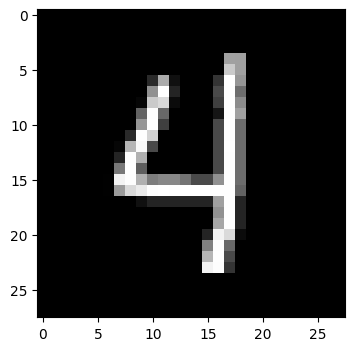

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(X_train[7,0,:],cmap='gray')  #8th sample, 1st matrix (there is only one), all pixels
plt.show()

Convolution takes an *input* image, and a *filter* . The output is a result of multiplying the filter values (pair-wise) at each location, and summing them all together. By using the same filter at every location in the input, we are exploting the spatial properties of the image. Here is an example of the computation taking place on a 2D image.

![alt text](https://camo.githubusercontent.com/3309220c48ab22c9a5dfe7656c3f1639b6b1755d/68747470733a2f2f7777772e64726f70626f782e636f6d2f732f6e3134713930677a386138726278622f32645f636f6e766f6c7574696f6e2e706e673f7261773d31)

Let's define a simple PyTorch layer to convert a tensor from (N, C, W, H) to (N, D=C\*W\*H). Despite being useful, PyTorch didn't implement one. We will use it later.

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
#Same training function as last time for our log-loss network
def train_log_loss_network(model, train_loader, val_loader=None, epochs=20, device="cpu"):
  loss_fn = nn.CrossEntropyLoss() #CrossEntropy is another name for the Logistic Regression loss function. Like before, we phrase learning as minimize a loss function. This is the loss we are going to minimize!

  #We need an optimizer! Adam is a good default one that works "well enough" for most problems
  #To tell Adam what to optimize, we give it the model's parameters - because thats what the learning will adjust
  optimizer = torch.optim.Adam(model.parameters())

  #Devices can be spcified by a string, or a special torch object
  #If it is a string, lets get the correct device
  if device.__class__ == str:
    device = torch.device(device)

  model.to(device)#Place the model on the correct compute resource
  for epoch in range(epochs):

    model = model.train()#Put our model in training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

      #Move the batch to the device we are using.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      y_pred = model(inputs)

      # Compute loss.
      loss = loss_fn(y_pred, labels.long())

      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its parameters
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)

    if val_loader is None:
      print("Loss after epoch {} is {}".format(epoch, running_loss))
    else:#Lets find out validation performance as we go!
      model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

      predictions = []
      targets = []

      for inputs, labels in test_loader:

        #Move the batch to the device we are using.
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        # Get predicted classes
        # y_pred will have a shape (Batch_size, C)
        #We are asking for which class had the largest response along dimension #1, the C dimension
        for pred in torch.argmax(y_pred, dim=1).cpu().numpy():
          predictions.append(pred)
        for l in labels.cpu().numpy():
          targets.append(l)

      #print("Network Accuracy: ", )
      print("Loss after epoch {} is {}. Accuracy: {}".format(epoch, running_loss, accuracy_score(predictions, targets)))

In [ ]:
#A simple convolutional neural network:
model = nn.Sequential(
  nn.Conv2d(1, 32, 3, padding=1), #We specify (input channels, filters/output-channels, filter-size, padding)
  #We use the padding option to control how the border is handled. Setting padding=(filter_size-1)/2 will give the 'same' behavior
  nn.ReLU(),
  Flatten(), #Convert from (B, C, H, W) ->(B, D). This way we can use a Linear layer after
  nn.Linear(32*d, C), #converts B*d to C=10
)

train_log_loss_network(model, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 12585.12358045578. Accuracy: 0.9662142857142857
Loss after epoch 1 is 4057.47729536891. Accuracy: 0.9744285714285714
Loss after epoch 2 is 2670.225022509694. Accuracy: 0.9762142857142857
Loss after epoch 3 is 2015.7502737939358. Accuracy: 0.9767142857142858
Loss after epoch 4 is 1578.9003928229213. Accuracy: 0.9782857142857143
Loss after epoch 5 is 1193.5217310395092. Accuracy: 0.9776428571428571
Loss after epoch 6 is 936.755296587944. Accuracy: 0.9783571428571428
Loss after epoch 7 is 708.3488984871656. Accuracy: 0.9792857142857143
Loss after epoch 8 is 608.3816822431982. Accuracy: 0.9766428571428571
Loss after epoch 9 is 443.53575054882094. Accuracy: 0.9775714285714285
Loss after epoch 10 is 380.71169757889584. Accuracy: 0.9785714285714285
Loss after epoch 11 is 293.6345214629546. Accuracy: 0.9765
Loss after epoch 12 is 265.0664907260798. Accuracy: 0.9769285714285715
Loss after epoch 13 is 212.42594566382468. Accuracy: 0.9784285714285714
Loss after epoch 14 is 9

Wow, a single convolutional layer was able to get really close to our best fully connected one. 98% accuracy!

To improve, we can try stacking a few layers, and including Batch-Norm and Dropout, which have spatial counterparts.


In [ ]:
model = nn.Sequential(
  nn.Conv2d(1, 32, 3, padding=1),
  nn.BatchNorm2d(32), #Batch norm happens on a channel basis, and so needs to know only how many channels are in the previous layer
  nn.Dropout2d(p=0.25), #Dropout also works on channels, and we usually use somewhere between 32-256 channels. So using the standard 50% can be a bit too agressive
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  Flatten(),
  nn.Linear(32*d, C),
)

train_log_loss_network(model, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 16238.191094785929. Accuracy: 0.9743571428571428
Loss after epoch 1 is 5831.541622191668. Accuracy: 0.9792857142857143
Loss after epoch 2 is 4252.3388181477785. Accuracy: 0.9804285714285714
Loss after epoch 3 is 3481.7160069048405. Accuracy: 0.9827857142857143
Loss after epoch 4 is 3031.044525153935. Accuracy: 0.9817857142857143
Loss after epoch 5 is 2718.8177448771894. Accuracy: 0.985
Loss after epoch 6 is 2401.056518036872. Accuracy: 0.9820714285714286
Loss after epoch 7 is 2211.6488073281944. Accuracy: 0.9840714285714286
Loss after epoch 8 is 1969.343087285757. Accuracy: 0.9851428571428571
Loss after epoch 9 is 1572.0800977870822. Accuracy: 0.9861428571428571
Loss after epoch 10 is 1461.5332184247673. Accuracy: 0.9852857142857143
Loss after epoch 11 is 1289.9273333298042. Accuracy: 0.9832142857142857
Loss after epoch 12 is 1236.3106078421697. Accuracy: 0.9866428571428572
Loss after epoch 13 is 1068.3798946896568. Accuracy: 0.9846428571428572
Loss after epoch 14

More improvement! Just a few layers got us up to ~98.7% accuracy. But its also starting to take a lot longer to train! This is normal, and part of why GPUs have become a necessity for doing CNNs. But we are also not done improving out CNNs!

It is possible to obtain a nice summary including the number of parameters to optimize:

In [ ]:
from torchsummary import summary
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         Dropout2d-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         Dropout2d-7           [-1, 32, 28, 28]               0
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
        Dropout2d-11           [-1, 32, 28, 28]               0
             ReLU-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           9,248
      BatchNorm2d-14           [-1, 32,

What happens if our input image is offset?

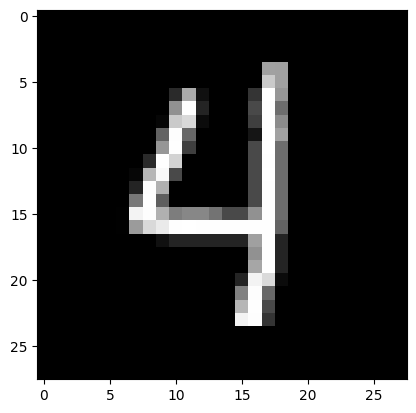

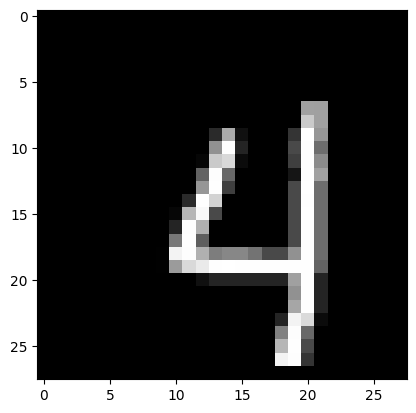

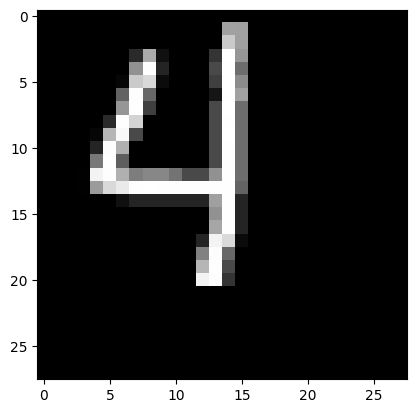

In [ ]:
img=X_train[7,0,:]

plt.imshow(img,cmap='gray')
plt.show()

img_lr = np.roll(np.roll(img, 3, axis=1), 3, axis=0)
img_ul = np.roll(np.roll(img, -3, axis=1), -3, axis=0)

plt.imshow(img_lr,cmap='gray')
plt.show()

plt.imshow(img_ul,cmap='gray')
plt.show()

In [ ]:
model = model.cpu().eval()

img_pred = nn.functional.softmax(model(torch.tensor(img[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()
img_lr_pred = nn.functional.softmax(model(torch.tensor(img_lr[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()
img_ul_pred = nn.functional.softmax(model(torch.tensor(img_ul[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()

print("Original Img Class 4 Prob:    " , img_pred[4])
print("Lower Right Img Class 4 Prob: " , img_lr_pred[4])
print("Upper Left Img Class 4 Prob:  " , img_ul_pred[4])

Original Img Class 4 Prob:     1.0
Lower Right Img Class 4 Prob:  9.9825964e-05
Upper Left Img Class 4 Prob:   0.9085894


Clearly, we want all three of the above examples to receive the same classification. They are *essentially* the same image, the content has just been shifted around.

What we desired is a property called  *translation invariance*. To be invariant to property X means that our ouput does not change based on X. We don't want translations (shifting up/down) to change our decisions. So we want to be *translation invariant*.

We can obtain some partial translation invariance with an operation known as *pooling*. Specifically, we will look at max-pooling.

What is max pooling? Similar to convolution, we will apply the same function to multiple locations in an image. We will generally stick to even sized pooling filters. And we will slide a function around the image that takes the maximum of all the inputs under consideration. A small 2D example looks like this:

![alt text](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

We apply this simple operation to every channel independently. If we do max-pooling with a 2x2 filter (the norm), we end up with an image 1/4 the size (half as many rows, and half as many columns)!

This also means we have less data to work with. What is commonly done in the comunity is to double the number of filters after every round of pooling, so that the amount of computation being done at every layer remains roughly  the same. Lets try it out!


In [ ]:
model_2 = nn.Sequential(
  nn.Conv2d(1, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.MaxPool2d(2), #This will do 2x2 filter with a stride of 2
  nn.ReLU(),
  nn.Conv2d(32, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.MaxPool2d(2),
  nn.ReLU(),
  nn.Conv2d(64, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  Flatten(),
  nn.Linear(32*d//(2*2), C), #we did 2 rounds of pooling by 2, so a 4*4 reducing in size , 2*2 for increasing in chanse, 2*2/(4*4) = 1/(2*2)
)

train_log_loss_network(model_2, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 9960.213825523853. Accuracy: 0.9837142857142858
Loss after epoch 1 is 3934.2248326577246. Accuracy: 0.9855
Loss after epoch 2 is 2899.2491647973657. Accuracy: 0.988
Loss after epoch 3 is 2477.8336280379444. Accuracy: 0.9888571428571429
Loss after epoch 4 is 1994.7947054449469. Accuracy: 0.9881428571428571
Loss after epoch 5 is 1711.3239022251219. Accuracy: 0.9918571428571429
Loss after epoch 6 is 1629.324664038606. Accuracy: 0.9915714285714285
Loss after epoch 7 is 1398.4619969055057. Accuracy: 0.9915714285714285
Loss after epoch 8 is 1267.9793850956485. Accuracy: 0.9909285714285714
Loss after epoch 9 is 1177.8778577274643. Accuracy: 0.9912857142857143
Loss after epoch 10 is 1079.3194809295237. Accuracy: 0.9928571428571429
Loss after epoch 11 is 1083.9289634153247. Accuracy: 0.9929285714285714
Loss after epoch 12 is 953.3750135386363. Accuracy: 0.9927857142857143
Loss after epoch 13 is 873.7414678616915. Accuracy: 0.9920714285714286
Loss after epoch 14 is 779.6977

In [ ]:
summary(model_2,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         Dropout2d-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         Dropout2d-7           [-1, 32, 28, 28]               0
         MaxPool2d-8           [-1, 32, 14, 14]               0
              ReLU-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 64, 14, 14]          18,496
      BatchNorm2d-11           [-1, 64, 14, 14]             128
        Dropout2d-12           [-1, 64, 14, 14]               0
             ReLU-13           [-1, 64, 14, 14]               0
           Conv2d-14           [-1, 64,

Same structure can be obtained in a more elegant way as seen below:

In [ ]:
def getBlock(in_size, out_size):
  return nn.Sequential(
    nn.Conv2d(in_size, out_size, 3, padding=1),
    nn.BatchNorm2d(out_size),
    nn.Dropout2d(p=0.25),
    nn.ReLU(),
    nn.Conv2d(out_size, out_size, 3, padding=1),
    nn.BatchNorm2d(out_size),
    nn.Dropout2d(p=0.25),
    nn.ReLU() )


model_example = nn.Sequential(
  getBlock(1, 32),
  nn.MaxPool2d(2), #This will do 2x2 filter with a stride of 2
  getBlock(32, 64),
  nn.MaxPool2d(2),
  getBlock(64, 128),
  Flatten(),
  nn.Linear(32*d//(2*2), C), #we did 2 rounds of pooling by 2, so a 4*4 reducing in size , 2*2 for increasing in chanse, 2*2/(4*4) = 1/(2*2)
)

train_log_loss_network(model_example, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 9988.869945660233. Accuracy: 0.9825714285714285
Loss after epoch 1 is 4146.287496395409. Accuracy: 0.9871428571428571
Loss after epoch 2 is 3044.605411944911. Accuracy: 0.9875
Loss after epoch 3 is 2472.2663592305034. Accuracy: 0.9892142857142857
Loss after epoch 4 is 2071.639071009122. Accuracy: 0.9903571428571428
Loss after epoch 5 is 1781.370679045096. Accuracy: 0.9877142857142858
Loss after epoch 6 is 1587.8397453781217. Accuracy: 0.9917142857142857
Loss after epoch 7 is 1529.82677947497. Accuracy: 0.993
Loss after epoch 8 is 1372.689517809078. Accuracy: 0.9932142857142857
Loss after epoch 9 is 1193.4234873396344. Accuracy: 0.9932142857142857
Loss after epoch 10 is 1119.5549691035412. Accuracy: 0.9932142857142857
Loss after epoch 11 is 936.6466978962999. Accuracy: 0.9915714285714285
Loss after epoch 12 is 902.9772092066705. Accuracy: 0.9932142857142857
Loss after epoch 13 is 830.8163327830844. Accuracy: 0.993
Loss after epoch 14 is 813.4260414205492. Accuracy:

By adding pooling, we got another bump in accuracy! Up to 99.3%!  

This is about as good as can be done on this dataset. You can seek out a bit more by playing with hyperparameters (layers, size of network, different types of pooling, different optimizers, different types of optimizers, more training epochs!), but in this case it won't be worth it.

Did this max-pooling solve our translation problem too?

In [ ]:
model_2 = model_2.cpu().eval()

img_pred = nn.functional.softmax(model_2(torch.tensor(img[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()
img_lr_pred = nn.functional.softmax(model_2(torch.tensor(img_lr[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()
img_ul_pred = nn.functional.softmax(model_2(torch.tensor(img_ul[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()

print("Original Img Class 4 Prob:    " , img_pred[4])
print("Lower Right Img Class 4 Prob: " , img_lr_pred[4])
print("Upper Left Img Class 4 Prob:   " , img_ul_pred[4])

Original Img Class 4 Prob:     1.0
Lower Right Img Class 4 Prob:  0.9659376
Upper Left Img Class 4 Prob:    0.9884448


So not quite *solved*, but better! This is why we said *partial* translation invariance.

Right now, our code requires every image to be the *exact* same size. We can actually make our algorithms a little more flexible than this, and also provide them with an even larger degre of translation invariance.

What we've currently been doing, is using Convolutions (+Pooling, Batch-Norm, ReLU, etc) to work in the spatial world, and then flatten the problem back to a fixed-dimensional task for a fully-connected layer. This means the sizes need to be consistent, and any change will throw it all off and we will get an error.

But, we can use a clever application of more convolutions, and pooling, to make it so that we could classify an image of *almost any* shape (i.e., Height, Width).

What we will do, is apply one last convolution, where we will use one channel for each class. Then we need to collapse the whole channel down to a single score. To do this, we will use what is called *Global Pooling*. Normal pooling we use a small sub-image. For Global pooling, we will use the entire activation map.

This gets us down to 1 output for each class, with *no fully connected layers anywhere*. Lets see it in action!

In [ ]:
class GlobalMaxPool2d(nn.Module):
    def forward(self, input):
        return nn.functional.max_pool2d(input, kernel_size=input.size()[2:])

In [ ]:
model_fully_conv = nn.Sequential(
  nn.Conv2d(1, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.MaxPool2d(2), #This will do 2x2 filter with a stride of 2
  nn.ReLU(),
  nn.Conv2d(32, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.MaxPool2d(2),
  nn.ReLU(),
  nn.Conv2d(64, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  #Now do a convolution with C filters, one for each class, and then perform global-max-pooling
  nn.Conv2d(128, C, 5), # it does not matter current H and W
  GlobalMaxPool2d(), # after global pooling H=1 and W=1
  Flatten()
)

train_log_loss_network(model_fully_conv, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 11759.507197797298. Accuracy: 0.9840714285714286
Loss after epoch 1 is 3730.7131449505687. Accuracy: 0.9879285714285714
Loss after epoch 2 is 2988.4682539626956. Accuracy: 0.9890714285714286
Loss after epoch 3 is 2425.451189201325. Accuracy: 0.9878571428571429
Loss after epoch 4 is 2061.812747631222. Accuracy: 0.9917142857142857
Loss after epoch 5 is 2061.6217499375343. Accuracy: 0.9909285714285714
Loss after epoch 6 is 1740.5948856398463. Accuracy: 0.992
Loss after epoch 7 is 1553.3127651335672. Accuracy: 0.992
Loss after epoch 8 is 1427.9716825727373. Accuracy: 0.9918571428571429
Loss after epoch 9 is 1352.3489429852925. Accuracy: 0.9917142857142857
Loss after epoch 10 is 1190.147970778402. Accuracy: 0.9915714285714285
Loss after epoch 11 is 1158.365355195012. Accuracy: 0.9925
Loss after epoch 12 is 1114.4152523797238. Accuracy: 0.9930714285714286
Loss after epoch 13 is 987.323503645137. Accuracy: 0.9925714285714285
Loss after epoch 14 is 876.0928588639945. Accu

In [ ]:
summary(model_fully_conv,(1,28,28))
# try also (1,56,56), same CNN can be used for other input sizes.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         Dropout2d-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         Dropout2d-7           [-1, 32, 28, 28]               0
         MaxPool2d-8           [-1, 32, 14, 14]               0
              ReLU-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 64, 14, 14]          18,496
      BatchNorm2d-11           [-1, 64, 14, 14]             128
        Dropout2d-12           [-1, 64, 14, 14]               0
             ReLU-13           [-1, 64, 14, 14]               0
           Conv2d-14           [-1, 64,

First, if we look out our shifted images, we see that they are much better classified now! Its not 100% invariant to the translations, but it has much less impact than before!

In [ ]:
model_fully_conv = model_fully_conv.cpu().eval()

img_pred = nn.functional.softmax(model_fully_conv(torch.tensor(img[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()
img_lr_pred = nn.functional.softmax(model_fully_conv(torch.tensor(img_lr[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()
img_ul_pred = nn.functional.softmax(model_fully_conv(torch.tensor(img_ul[np.newaxis,np.newaxis,...])), dim=1).detach().numpy().flatten()

print("Original Img Class 4 Prob:    " , img_pred[4])
print("Lower Right Img Class 4 Prob: " , img_lr_pred[4])
print("Upper Left Img Class 4 Prob:   " , img_ul_pred[4])

Original Img Class 4 Prob:     1.0
Lower Right Img Class 4 Prob:  0.9999999
Upper Left Img Class 4 Prob:    0.9863647


## PyTorch image classification with pre-trained networks

Source: https://pyimagesearch.com/2021/07/26/pytorch-image-classification-with-pre-trained-networks/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/"

 391_notebooks			    data602-lectures-main-ChrisMcGraw
 4453_notebooks			    IBM_Skills_Network_notebooks
 463_602_notebooks		    image_triplet_loss-master
 506_notebooks			    introduction_to_ml_with_python-master
 602_lecture_notes_Fall2022.zip     iris_gray.jpg
 602_recordings			    iris_petal_sepal_k.png
 ADNI_Clinical_Features.ipynb	    mnist.ipynb
 ADNI_Combined_Features_new.ipynb  'Muller and Guido - Intro_ML_Python.pdf'
 baboon.png			    question_figures
 CBIR				    surgery
'Colab Notebooks'		    XAI
 cs230_notebooks


In [16]:
import torch
import torchvision
from torchvision import models
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
#These are the ImageNet labels (1000 class). We need it to understand what for instance 312th class refers to.
IN_LABELS = "/content/drive/MyDrive/506_notebooks/ilsvrc2012_wordnet_lemmas.txt"

In [8]:
def preprocess_image(image):
	# if image is read by openCV swap the color channels from BGR to RGB
	#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	# resize it, and scale the pixel values to [0, 1] range
	image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
	image = image.astype("float32") / 255.0
	# subtract ImageNet mean, divide by ImageNet standard deviation,
	# set "channels first" ordering, and add a batch dimension
	image -= MEAN
	image /= STD
	image = np.transpose(image, (2, 0, 1))
	image = np.expand_dims(image, 0)
	# return the preprocessed image
	return image

In [9]:
# define a dictionary that maps model names to their classes
# inside torchvision
MODELS = {
	"vgg16": models.vgg16(pretrained=True),
	"vgg19": models.vgg19(pretrained=True),
	"inception": models.inception_v3(pretrained=True),
	"densenet": models.densenet121(pretrained=True),
	"resnet": models.resnet50(pretrained=True)
}
# load our the network weights from disk, flash it to the current
# device, and set it to evaluation mode
model = MODELS["vgg16"].to(DEVICE)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 115MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
from skimage import io
cat = io.imread('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images%20/images_part_1/cat.png')

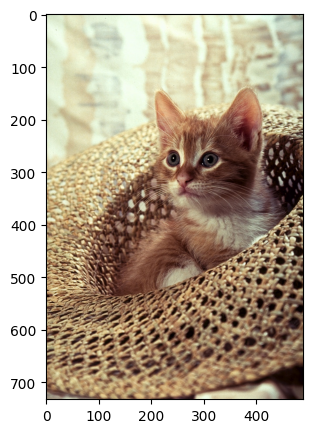

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(cat)
plt.show()

In [17]:
image = preprocess_image(cat)

In [18]:
# convert the preprocessed image to a torch tensor and flash it to the current device
image = torch.from_numpy(image)
image = image.to(DEVICE)

In [19]:
# load the preprocessed the ImageNet labels
imagenetLabels = dict(enumerate(open(IN_LABELS)))

In [22]:
# classify the image and extract the predictions
logits = model(image)
probabilities = torch.nn.Softmax(dim=-1)(logits)
sortedProba = torch.argsort(probabilities, dim=-1, descending=True)

In [32]:
# loop over the predictions and display the rank-5 predictions and
# corresponding probabilities to our terminal
for (i, idx) in enumerate(sortedProba[0, :5]):
	print("{}. {}: {:.2f}%".format
		(i, imagenetLabels[idx.item()].strip(),
		probabilities[0, idx.item()] * 100))

0. Egyptian_cat: 19.64%
1. tiger_cat: 8.78%
2. tabby, tabby_cat: 6.29%
3. window_screen: 5.03%
4. chain_mail, ring_mail, mail, chain_armor, chain_armour, ring_armor, ring_armour: 4.16%
